### In this notebook we will calibrate forward model from monochromator measurements, and make a dataset. 

To calibrate, I need the dispersion from the center, the standard deviation of gaussian of each peak

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.abspath('../../')
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
import forward.fourier.method as fwd
from forward.fourier.kernel_creator import create_fourier_kernel
from skimage.feature import peak_local_max
from scipy.ndimage import center_of_mass, shift

from torchvision.transforms import GaussianBlur


import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


%load_ext autoreload
%autoreload 2

/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
dir = '/project/agdoepp/Experiment/Hyperspectral_Calibration_FTS/microlens_18012024_new/'

files = os.listdir(dir)
files = [f for f in files if f.endswith('.npy')]

In [3]:
order = np.argsort([int(f[:3]) for f in files])
files = np.array(files)[order]
files = files[25:-24] #750 to 850

bitdepth = 16
# orientation = 'straight'

cube = torch.stack([torch.tensor((np.load(dir + file) / 2**bitdepth).astype(np.float32)) for file in files])# if str(bitdepth) in file and orientation in file and 'tiff' in file])

cube = torch.nan_to_num(cube, nan = torch.nan_to_num(cube).max())

n_wl = cube.shape[0]
mid_wl = n_wl // 2
# image = torch.mean(images, dim=(0))

# image = image[700:1200,950:1450]

# cube = cube / torch.max(cube)

# bitrate = 1 / images.unique()[1] 



### First thing is to correct for any laser drift.
Find the position of the main spot for each wavelength. Then we will shift each cube slice by that amount.

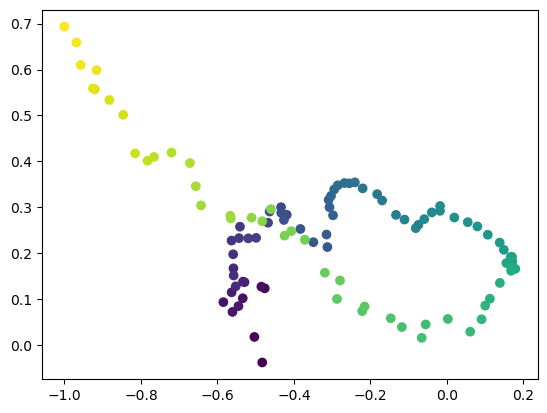

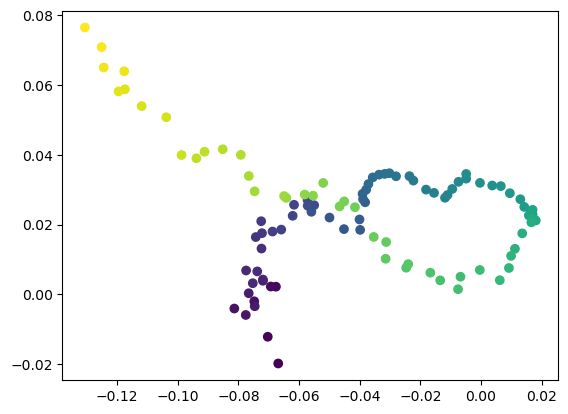

In [4]:
f_border = 20

for i in range(2):
    main_spot_loc = peak_local_max(cube.sum(0).numpy(), num_peaks=1)[0]


    main_spot_CoM_wl = np.zeros((2,cube.shape[0]))

    for i in range(cube.shape[0]):
        main_spot_CoM_wl[:,i] = center_of_mass(cube[i,main_spot_loc[0]-f_border:main_spot_loc[0]+f_border+1,main_spot_loc[1]-f_border:main_spot_loc[1]+f_border+1].numpy().astype(np.float32))

    main_spot_CoM_wl -= f_border

    plt.figure()
    plt.scatter(main_spot_CoM_wl[0],main_spot_CoM_wl[1],c=np.arange(len(cube)),cmap='viridis')

    for i in range(cube.shape[0]):
        cube[i] = torch.tensor(shift(cube[i],-main_spot_CoM_wl[:,i],order=1))

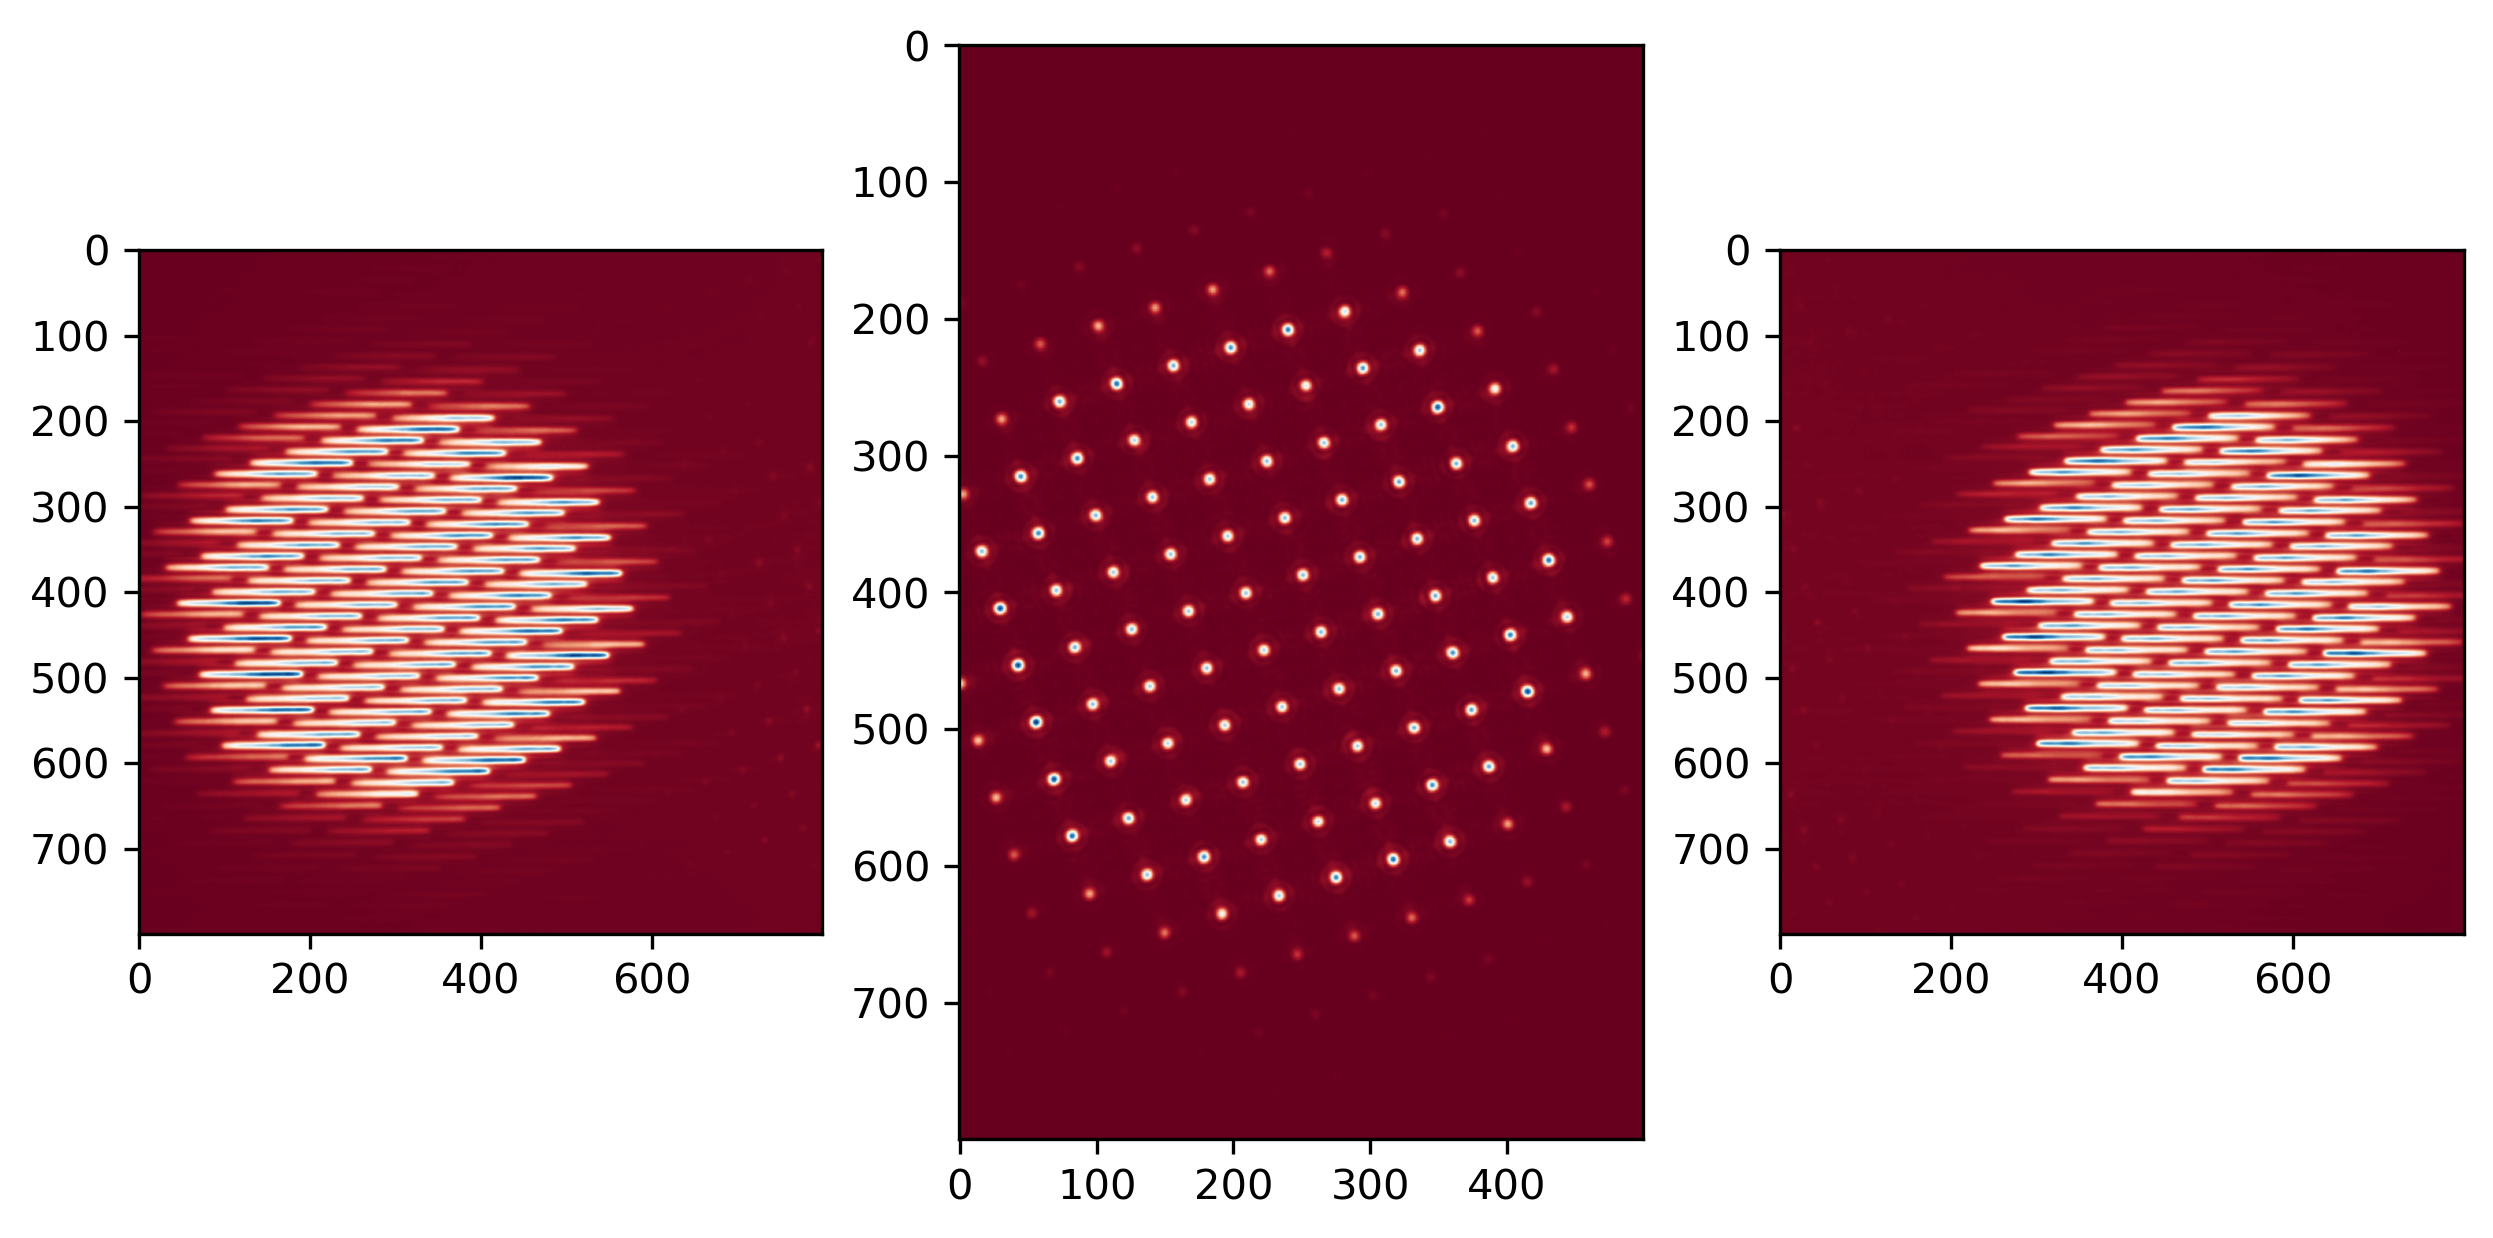

In [5]:
fig,ax = plt.subplots(1,3,figsize=(10,10),dpi=300)
ax[0].imshow(cube.sum(0)[:,:800],cmap='RdBu')
ax[1].imshow(cube.sum(0)[:,1000:1500],cmap='RdBu')
ax[2].imshow(cube.sum(0)[:,-800:],cmap='RdBu')

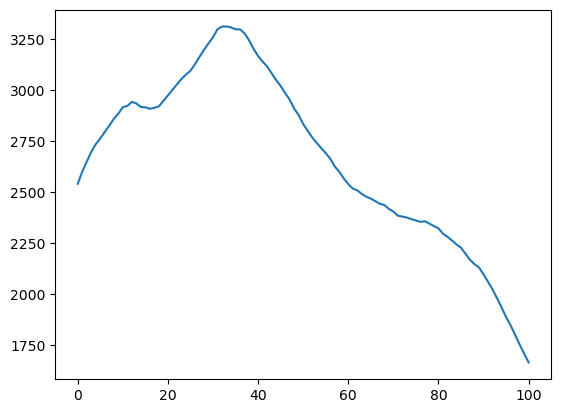

In [6]:
plt.plot(cube.sum(dim=(1,2)))

#### Now we have loaded the data, i want to find gaussian parameters, as well as the CoM for each peak
The way I will draw the boxes, is I will know the location of the center peak for each wavelength. I will also know the locations of all the peaks for the middle wavelength.  

In [7]:
import scipy.optimize as opt

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, offset):
    x, y = xy
    xo = float(xo)
    yo = float(yo)
    theta = 0    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    # b = -np.sin(2*theta)/(4*sigma_x**2) + np.sin(2*theta)/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    # g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + c*((y-yo)**2)))
    return g.ravel()

In [8]:
main_spot_loc

array([ 495, 1056])

In [9]:


peak_loc_minus1 = np.zeros((2,len(cube)),dtype=int)
peak_loc_plus1 = np.zeros((2,len(cube)),dtype=int)
peak_loc_funda = np.zeros((2,len(cube)),dtype=int)

com_main_minus1 = np.zeros((2,len(cube)))
com_main_plus1 = np.zeros((2,len(cube)))
com_main_funda = np.zeros((2,len(cube)))

std_main_minus1 = np.zeros((2,len(cube)))
std_main_plus1 = np.zeros((2,len(cube)))
std_main_funda = np.zeros((2,len(cube)))

intensity_minus1 = np.zeros((len(cube)))
intensity_plus1 = np.zeros((len(cube)))
intensity_funda = np.zeros((len(cube)))

border = 20
x = np.arange(border*2+1)
y = np.arange(border*2+1)
x,y = np.meshgrid(x, y)
initial_guess = (1,border,border,3,3,0)

funda = cube[:,900:1500]

main_spot_loc = peak_local_max(cube.sum(0).numpy(), num_peaks=1)[0]



for i in range(len(cube)):
    # print(i)
    peak_loc_minus1[:,i] = peak_local_max(cube[i,main_spot_loc[0]-10:main_spot_loc[0] + 10+1,:700].numpy(), num_peaks=1) + np.array([main_spot_loc[0]-10,0])
    peak_loc_plus1[:,i] = peak_local_max(cube[i,main_spot_loc[0]-10:main_spot_loc[0] + 10+1,1750:].numpy(), num_peaks=1) + np.array([main_spot_loc[0]-10,1750]) ## THIS ASSUMES THE GRATING IS FAIRLY HORIZONTAL
    peak_loc_funda[:,i] = peak_local_max(cube[i,main_spot_loc[0]-10:main_spot_loc[0] + 10+1,900:1500].numpy(), num_peaks=1) + np.array([main_spot_loc[0]-10,900])

    
    minus1data = cube[i, peak_loc_minus1[0,i]-border:peak_loc_minus1[0,i]+border+1,peak_loc_minus1[1,i]-border:peak_loc_minus1[1,i]+border+1].numpy().ravel()        
    plus1data = cube[i, peak_loc_plus1[0,i]-border:peak_loc_plus1[0,i]+border+1,peak_loc_plus1[1,i]-border:peak_loc_plus1[1,i]+border+1].numpy().ravel()
    fundadata = cube[i, peak_loc_funda[0,i]-border:peak_loc_funda[0,i]+border+1,peak_loc_funda[1,i]-border:peak_loc_funda[1,i]+border+1].numpy().ravel()

    try:
        popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), minus1data, p0=initial_guess)

        # com_main_minus1[:,i] = popt[1:3]
        com_main_minus1[:,i] = center_of_mass(minus1data.reshape((border*2+1,border*2+1)))
        std_main_minus1[:,i] = popt[3:5]
        intensity_minus1[i] = popt[0]
    except:
        com_main_minus1[:,i] = np.nan
        std_main_minus1[:,i] = np.nan
        break

    try:
        popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), plus1data, p0=initial_guess)

        # com_main_plus1[:,i] = popt[1:3]
        com_main_plus1[:,i] = center_of_mass(plus1data.reshape((border*2+1,border*2+1)))
        std_main_plus1[:,i] = popt[3:5]
        intensity_plus1[i] = popt[0]
    except:
        com_main_plus1[:,i] = np.nan
        std_main_plus1[:,i] = np.nan
        break

    try:
        popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), fundadata, p0=initial_guess)

        # com_main_funda[:,i] = popt[1:3]
        com_main_funda[:,i] = center_of_mass(fundadata.reshape((border*2+1,border*2+1)))
        std_main_funda[:,i] = popt[3:5]
        intensity_funda[i] = popt[0]
    except:
        com_main_funda[:,i] = np.nan
        std_main_funda[:,i] = np.nan
        break


com_main_minus1 += peak_loc_minus1 - border
com_main_plus1 += peak_loc_plus1 - border
com_main_funda += peak_loc_funda - border

#relative to the middle wavelength
rel_peak_loc_funda = peak_loc_funda - peak_loc_funda[:,mid_wl][:,None]
rel_peak_loc_minus1 = peak_loc_minus1 - peak_loc_minus1[:,mid_wl][:,None]
rel_peak_loc_plus1 = peak_loc_plus1 - peak_loc_plus1[:,mid_wl][:,None]

rel_com_main_funda = com_main_funda - com_main_funda[:,mid_wl][:,None]
rel_com_main_minus1 = com_main_minus1 - com_main_minus1[:,mid_wl][:,None]
rel_com_main_plus1 = com_main_plus1 - com_main_plus1[:,mid_wl][:,None]

std_main_minus1 = std_main_minus1[[1,0]]
std_main_plus1 = std_main_plus1[[1,0]]
std_main_funda = std_main_funda[[1,0]]


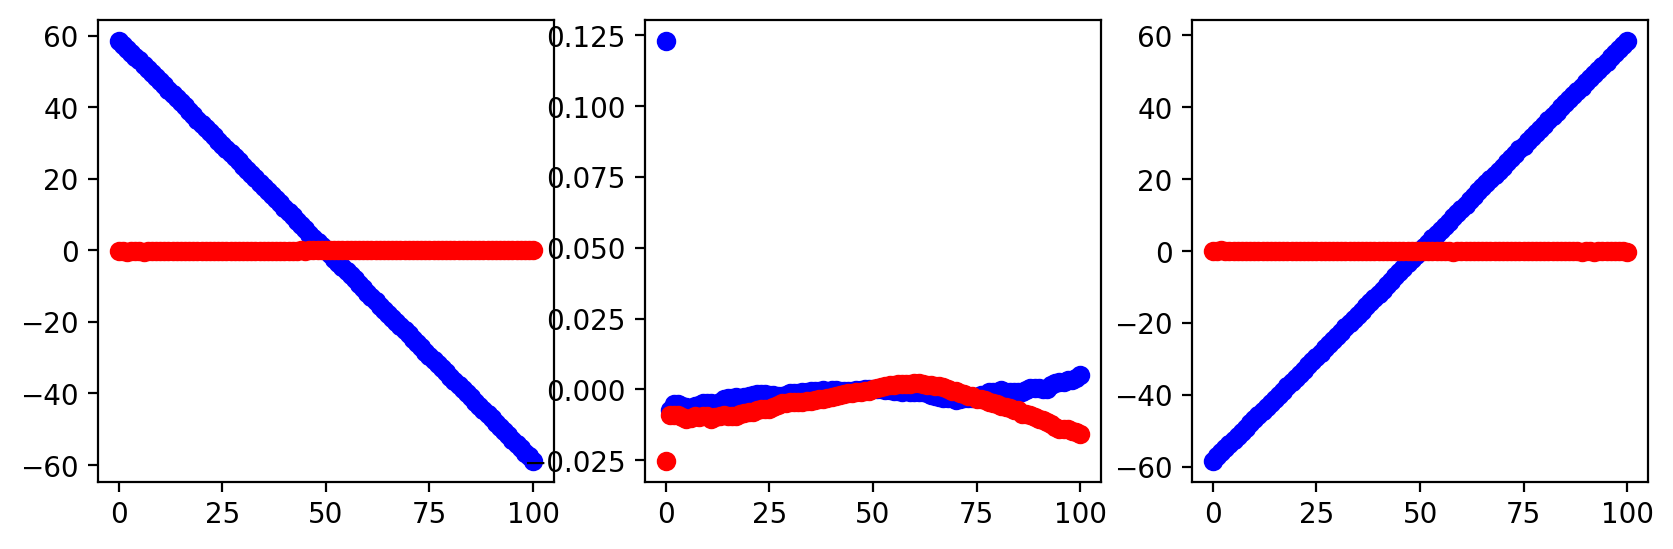

In [10]:
fig,ax = plt.subplots(1,3,figsize = (10,3),dpi=200)
ax[0].scatter(np.arange(n_wl),rel_com_main_minus1[1],c='b')#,rel_peak_loc_minus1[0])
ax[0].scatter(np.arange(n_wl),rel_com_main_minus1[0],c='r')#,rel_peak_loc_minus1[0])
ax[1].scatter(np.arange(n_wl),rel_com_main_funda[1],c='b')#,rel_peak_loc_minus1[0])
ax[1].scatter(np.arange(n_wl),rel_com_main_funda[0],c='r')#,rel_peak_loc_minus1[0])
ax[2].scatter(np.arange(n_wl),rel_com_main_plus1[1],c='b')#,rel_peak_loc_minus1[0])
ax[2].scatter(np.arange(n_wl),rel_com_main_plus1[0],c='r')#,rel_peak_loc_minus1[0])


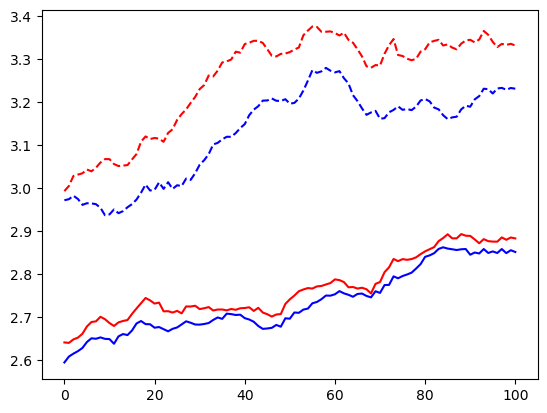

In [11]:
plt.plot(std_main_plus1[0],'b')
plt.plot(std_main_minus1[0],'r')
plt.plot(std_main_plus1[1],'b--')
plt.plot(std_main_minus1[1],'r--')

In [12]:
torch.save(std_main_plus1,dir + 'std_main_plus1.pt')
torch.save(std_main_minus1,dir + 'std_main_minus1.pt')
torch.save(std_main_funda,dir + 'std_main_funda.pt')

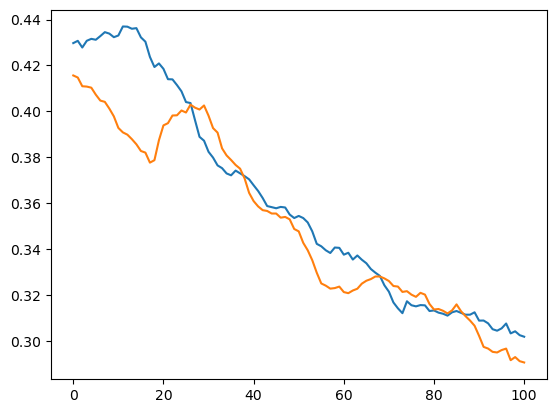

In [25]:
### Calculate the dispersion of each
abs_dispersion_minus1 = com_main_minus1 - com_main_funda 
abs_dispersion_plus1 = com_main_plus1 - com_main_funda

torch.save(abs_dispersion_plus1,dir + 'abs_dispersion_plus1.pt')
torch.save(abs_dispersion_minus1,dir + 'abs_dispersion_minus1.pt')

### Calculate the intensity modulations due to grating
intensity_modulation_minus1 = intensity_minus1 / intensity_funda
intensity_modulation_plus1 = intensity_plus1 / intensity_funda

plt.plot(intensity_modulation_minus1)
plt.plot(intensity_modulation_plus1)

In [14]:
kernel = torch.zeros_like(cube)

center = np.array([cube.shape[1]//2,cube.shape[2]//2])

for i in range(len(cube)):
    # com = com_main_funda[:,i]
    # kernel[i,np.ceil(com[0]).astype(int),np.ceil(com[1]).astype(int)] = com[1] % 1 * com[0] % 1
    # kernel[i,np.ceil(com[0]).astype(int),np.floor(com[1]).astype(int)] = com[1] % 1 * (1 - com[0] % 1)
    # kernel[i,np.floor(com[0]).astype(int),np.ceil(com[1]).astype(int)] = (1 - com[1] % 1) * com[0] % 1
    # kernel[i,np.floor(com[0]).astype(int),np.floor(com[1]).astype(int)] = (1 - com[1] % 1) * (1 - com[0] % 1)
    kernel[i,center[0],center[1]] = 1

    com = com_main_minus1[:,i] - com_main_funda[:,i] + center
    kernel[i,np.ceil(com[0]).astype(int),np.ceil(com[1]).astype(int)] = (com[1] % 1) * (com[0] % 1)
    kernel[i,np.ceil(com[0]).astype(int),np.floor(com[1]).astype(int)] = (com[1] % 1) * (1 - com[0] % 1)
    kernel[i,np.floor(com[0]).astype(int),np.ceil(com[1]).astype(int)] = (1 - com[1] % 1) * (com[0] % 1)
    kernel[i,np.floor(com[0]).astype(int),np.floor(com[1]).astype(int)] = (1 - com[1] % 1) * (1 - com[0] % 1)


    com = com_main_plus1[:,i] - com_main_funda[:,i] + center
    # print(com)
    kernel[i,np.ceil(com[0]).astype(int),np.ceil(com[1]).astype(int)] = (com[1] % 1) * (com[0] % 1)
    kernel[i,np.ceil(com[0]).astype(int),np.floor(com[1]).astype(int)] = (com[1] % 1) * (1 - com[0] % 1)
    kernel[i,np.floor(com[0]).astype(int),np.ceil(com[1]).astype(int)] = (1 - com[1] % 1) * (com[0] % 1)
    kernel[i,np.floor(com[0]).astype(int),np.floor(com[1]).astype(int)] = (1 - com[1] % 1) * (1 - com[0] % 1)

    # kernel[i,:,:700] *= intensity_modulation_minus1[i]
    # kernel[i,:,1750:] *= intensity_modulation_plus1[i]

    # kernel[i] /= torch.sum(kernel[i])


kernel = kernel.unsqueeze(0).to(device)

torch.save(kernel,dir + 'microlens_kernel.pt')

At this point can use the grating calibration notebook to get the grating response

In [15]:
grating_modulation_m1 = torch.load(dir+'microlens_grating_modulation_m1.pt').to(device)
grating_modulation_p1 = torch.load(dir+'microlens_grating_modulation_p1.pt').to(device)

In [16]:
just_funda = cube.clone()

just_funda[...,:750] = 0
just_funda[...,-750:] = 0

just_funda = just_funda.unsqueeze(0).to(device)

In [17]:
grating_modulation_m1.mean()

tensor(0.4208, device='cuda:0')

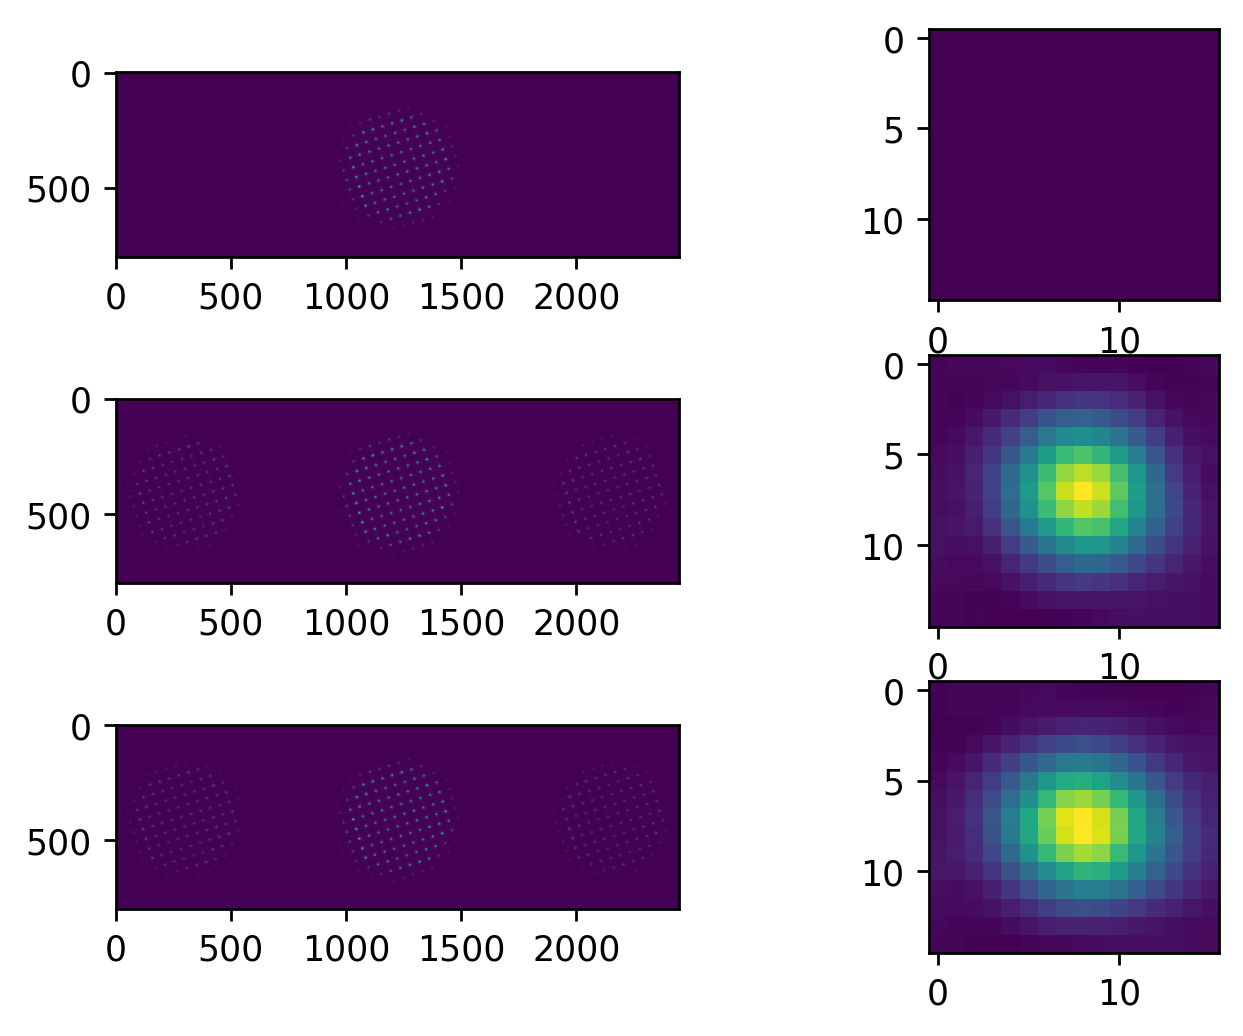

In [18]:
dispersed_cube = fwd.disperser.disperse_all_orders(just_funda, kernel)

dispersed_cube[...,:750] *= grating_modulation_m1
dispersed_cube[...,-750:] *= grating_modulation_p1

fig,ax = plt.subplots(3,2,dpi=250)
ax[0,0].imshow(just_funda[0,mid_wl].cpu().numpy())
ax[1,0].imshow(dispersed_cube[0,mid_wl].cpu())
ax[2,0].imshow(cube[mid_wl])

ax[0,1].imshow(just_funda[0,mid_wl,335:350,2017:2033].cpu().numpy())
ax[1,1].imshow(dispersed_cube[0,mid_wl,335:350,2017:2033].cpu())
ax[2,1].imshow(cube[mid_wl,335:350,2017:2033])


### Now we have the dispersions and the stds. This marks the end of calibration

### Now lets make some simulated measurements...

We need to make the funda_cube (the ground truth). Then disperse and integrate (also add noise). Finally, we extract boxes around the peaks.

The training data is boxes around the -1, +1 and funda for a given peak. The output is the spectral intensity phase.  For the dispersed orders, the box-finding method will cause the middle wavelength to be in the middle pixel, and the box_size is determeined by the dispersion. 

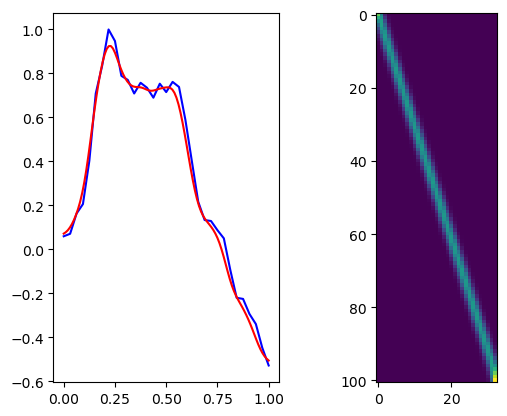

In [19]:
calibration_measurement = cube.sum(0)
calibration_neighbour_peaks = peak_local_max(calibration_measurement[:,900:1500].numpy(), min_distance=30, threshold_rel = 0.01) + np.array([0,900])[None,:]


def first_order_shift(array, shiftx, shifty):
    ''' shiftx and shifty can be floats.
    '''
    shifted = (torch.roll(array, (int(torch.ceil(shiftx)) , int(torch.ceil(shifty))), dims=(0,1)) * (shiftx % 1) * (shifty % 1) +
                torch.roll(array, (int(torch.ceil(shiftx)) , int(torch.floor(shifty))), dims=(0,1)) * (shiftx % 1) * (1 - shifty % 1) +
                torch.roll(array, (int(torch.floor(shiftx)) , int(torch.ceil(shifty))), dims=(0,1)) * (1 - shiftx % 1) * (shifty % 1) +
                torch.roll(array, (int(torch.floor(shiftx)) , int(torch.floor(shifty))), dims=(0,1)) * (1 - shiftx % 1) * (1 - shifty % 1))
    return shifted
               
               


def simulate_measurement(just_funda, new_intensities, new_phase_x, new_phase_y, peak_locs, kernel, grating_modulation_m1, grating_modulation_p1, border = 20):
    '''
    new intensities and phases are the intensity and phase for each peak and wavelength. Phases are just in pixel shift.
    '''
    new_cube = just_funda.clone()

    for i,peak in enumerate(peak_locs):
        for wl in range(len(new_intensities)):

            new_cube[0,wl,peak[0]-border:peak[0]+border+1,peak[1]-border:peak[1]+border+1] = first_order_shift(just_funda[0,wl,peak[0]-border:peak[0]+border+1,peak[1]-border:peak[1]+border+1], new_phase_x[wl,i], new_phase_y[wl,i]) * new_intensities[wl,i]
        
        #normalize each spots total intensity in funda
        new_cube[0,:,peak[0]-border:peak[0]+border+1,peak[1]-border:peak[1]+border+1] = new_cube[0,:,peak[0]-border:peak[0]+border+1,peak[1]-border:peak[1]+border+1] / torch.sum(new_cube[0,:,peak[0]-border:peak[0]+border+1,peak[1]-border:peak[1]+border+1])

    dispersed_cube = fwd.disperser.disperse_all_orders(new_cube, kernel)

    dispersed_cube[...,:750] *= grating_modulation_m1
    dispersed_cube[...,-750:] *= grating_modulation_p1

    return dispersed_cube

def create_random_smooth_array(N, smoothness = 8, positive = False, max_val = 1):
    '''
    Creates a random smooth array of length N
    '''
    # Number of points in the array
    num_points = N + 30
    kernelsize = smoothness * 2


    # Create a random smooth array
    random_smooth_array = torch.cumsum(torch.randn(num_points),dim=0)

    sigma = (torch.rand(1) -.5) *smoothness + smoothness

    gaussian = torch.exp(torch.linspace(-1,1,kernelsize)**2 / (2*sigma**2))
    gaussian /= torch.sum(gaussian)

    smoother = nn.functional.conv1d(random_smooth_array.unsqueeze(0).unsqueeze(0), gaussian.unsqueeze(0).unsqueeze(0), padding = kernelsize//2).squeeze(0).squeeze(0)

    if positive:
        smoother -= torch.min(smoother)


    if len(smoother) > N:  
        smoother = smoother[:N]

    smoother /= torch.max(smoother.abs()) / max_val
    
    return smoother


gaussian_size = 3

latentsize = n_wl//gaussian_size

latent_signal = create_random_smooth_array(latentsize,positive=False,smoothness=2,max_val=1)

correlation_matrix = torch.zeros((n_wl,len(latent_signal)))
for i in range(len(latent_signal)):
    mu = i * n_wl/latentsize
    correlation_matrix[:,i] = torch.exp(-(torch.arange(n_wl) - mu)**2 / (2 * gaussian_size**2)) 

correlation_matrix = correlation_matrix / torch.sum(correlation_matrix, dim=1, keepdim=True)

torch.save(correlation_matrix,dir + 'correlation_matrix.pt')

full_signal = correlation_matrix@latent_signal


fig,ax = plt.subplots(1,2)


ax[0].plot(np.linspace(0,1,latentsize), latent_signal,'b')
ax[0].plot(np.linspace(0,1,n_wl),full_signal,'r')
ax[1].imshow(correlation_matrix)

In [20]:
#make a version of fundamental, where all spots are normalized to the same intensity, and also flat spectra (we'll modulate it later)
normalized_just_funda = torch.zeros_like(just_funda)

for i in range(len(calibration_neighbour_peaks)):
    peak = just_funda[0,:,calibration_neighbour_peaks[i,0]-20:calibration_neighbour_peaks[i,0]+20+1,calibration_neighbour_peaks[i,1]-20:calibration_neighbour_peaks[i,1]+20+1]

    peak = peak/torch.sum(peak, dim=(1,2), keepdim=True)

    normalized_just_funda[0,:,calibration_neighbour_peaks[i,0]-20:calibration_neighbour_peaks[i,0]+20+1,calibration_neighbour_peaks[i,1]-20:calibration_neighbour_peaks[i,1]+20+1] = peak / torch.sum(peak)


#### Simulate a measurement with random phase

In [21]:

new_intensities = torch.stack([correlation_matrix@create_random_smooth_array(latentsize, positive=True, smoothness = 2) for i in range(len(calibration_neighbour_peaks))]).permute(1,0)
new_intensities[:,:5] = 0
new_intensities[:20,0]= 1
new_intensities[20:40,1]= 1
new_intensities[40:60,2]= 1
new_intensities[60:80,3]= 1
new_intensities[80:100,4]= 1


    
new_phase_x = torch.stack([correlation_matrix@create_random_smooth_array(latentsize, max_val = (torch.rand(1) - .5) * 3, smoothness=2) for i in range(len(calibration_neighbour_peaks))]).permute(1,0)
new_phase_y = torch.stack([correlation_matrix@create_random_smooth_array(latentsize, max_val = (torch.rand(1) - .5) * 3, smoothness=2) for i in range(len(calibration_neighbour_peaks))]).permute(1,0)

newcube = simulate_measurement(normalized_just_funda, new_intensities, new_phase_x, new_phase_y, calibration_neighbour_peaks, kernel, grating_modulation_m1, grating_modulation_p1)

measurement = newcube.sum(1)
neighbour_peaks = peak_local_max(measurement[0,:,900:1500].cpu().numpy(), min_distance=30, threshold_rel = 0.01) + np.array([0,900])[None,:]

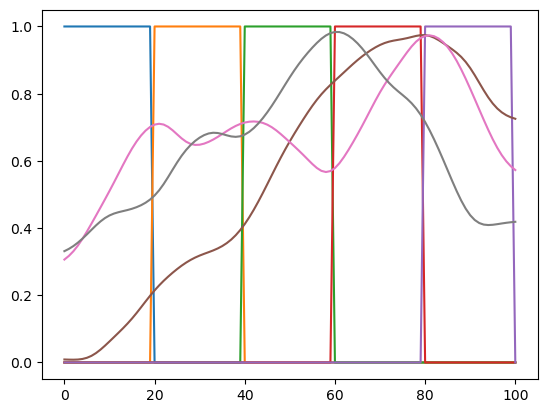

In [22]:
plt.plot(new_intensities[:,:8]);

### Now the process of extracting the boxes:


In [24]:
distances_to_center = abs(abs_dispersion_minus1[1,mid_wl] - abs_dispersion_minus1[1,0]), abs(abs_dispersion_minus1[1,mid_wl] - abs_dispersion_minus1[1,-1]), abs(abs_dispersion_plus1[1,mid_wl] - abs_dispersion_plus1[1,0]), abs(abs_dispersion_plus1[1,mid_wl] - abs_dispersion_plus1[1,-1])
box_size = np.ceil(np.max(distances_to_center)).astype(int)
print(box_size, np.std(distances_to_center))
disp_height = 6

59 0.1329049508727993


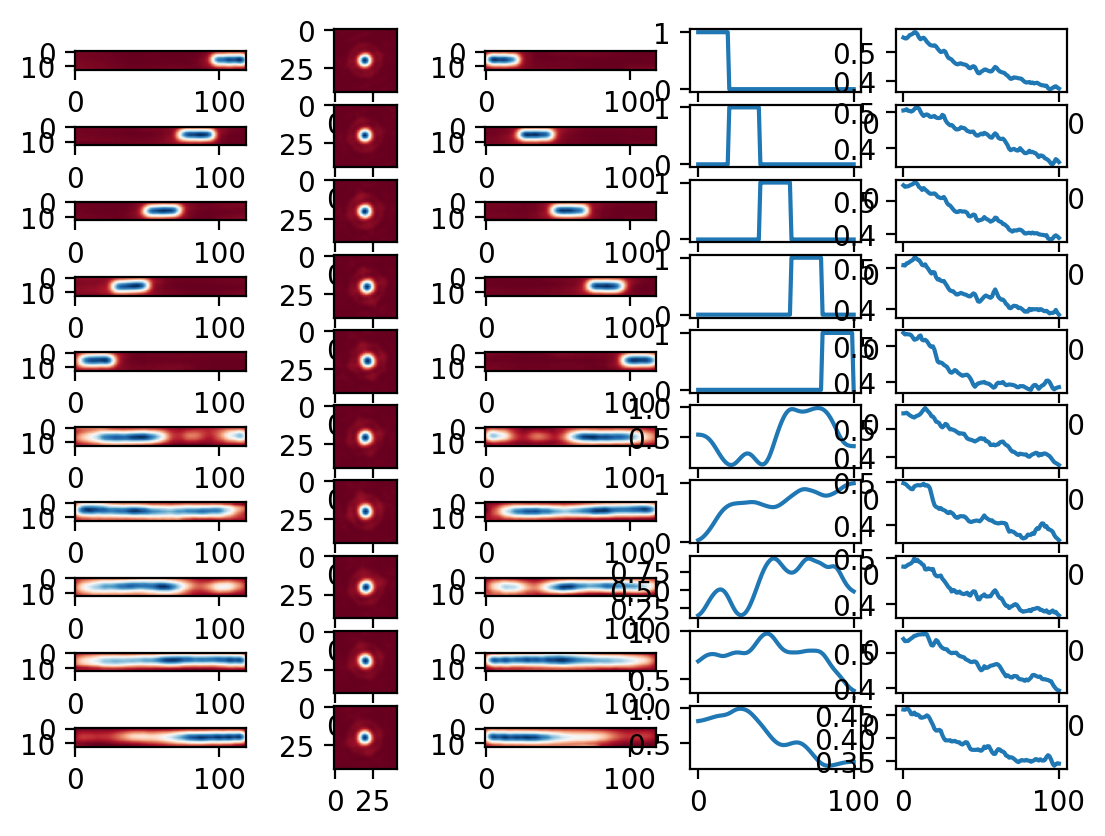

In [37]:
num_peaks = 60

# neighbour_peaks = neighbour_peaks[:num_peaks]
neighbour_peaks = calibration_neighbour_peaks[:num_peaks]

center_wl_peak_positions_m1_exact = neighbour_peaks + abs_dispersion_minus1[:,mid_wl][None]
center_wl_peak_positions_m1 = np.round(center_wl_peak_positions_m1_exact).astype(int)
# m1_rounding_correction = center_wl_peak_positions_m1_exact - center_wl_peak_positions_m1

center_wl_peak_positions_p1_exact = neighbour_peaks + abs_dispersion_plus1[:,mid_wl][None]
center_wl_peak_positions_p1 = np.round(center_wl_peak_positions_p1_exact).astype(int)
# p1_rounding_correction = center_wl_peak_positions_p1_exact - center_wl_peak_positions_p1



center_wl_peak_positions_f = np.round(neighbour_peaks).astype(int)
# f_rounding_correction = neighbour_peaks - center_wl_peak_positions_f


all_peaks_m1 = neighbour_peaks[:,:,None] + abs_dispersion_minus1[None,:,:,]



border = 6
fborder = 20

fig,ax = plt.subplots(10,5,dpi=200)

# for i,peakno in enumerate(np.linspace(0,len(center_wl_peak_positions_m1)-1,10).astype(int)):
for i,peakno in enumerate(np.arange(10)):
    ax[i,0].imshow(measurement[0,center_wl_peak_positions_m1[peakno,0]-border:center_wl_peak_positions_m1[peakno,0]+border+1,center_wl_peak_positions_m1[peakno,1]-box_size:center_wl_peak_positions_m1[peakno,1]+box_size+1].cpu(),cmap='RdBu')
    ax[i,1].imshow(measurement[0,center_wl_peak_positions_f[peakno,0]-fborder:center_wl_peak_positions_f[peakno,0]+fborder+1,center_wl_peak_positions_f[peakno,1]-fborder:center_wl_peak_positions_f[peakno,1]+fborder+1].cpu(),cmap='RdBu')
    ax[i,2].imshow(measurement[0,center_wl_peak_positions_p1[peakno,0]-border:center_wl_peak_positions_p1[peakno,0]+border+1,center_wl_peak_positions_p1[peakno,1]-box_size:center_wl_peak_positions_p1[peakno,1]+box_size+1].cpu(),cmap='RdBu')
    
    full_peak_positions_m1 = all_peaks_m1[peakno].astype(int)
    grating_response_m1 = torch.stack([grating_modulation_m1[0,wl,full_peak_positions_m1[0,wl],full_peak_positions_m1[1,wl]] for wl in range(n_wl)])
    
    ax[i,3].plot(new_intensities[:,peakno])# * 
    ax[i,4].plot(grating_response_m1.cpu())

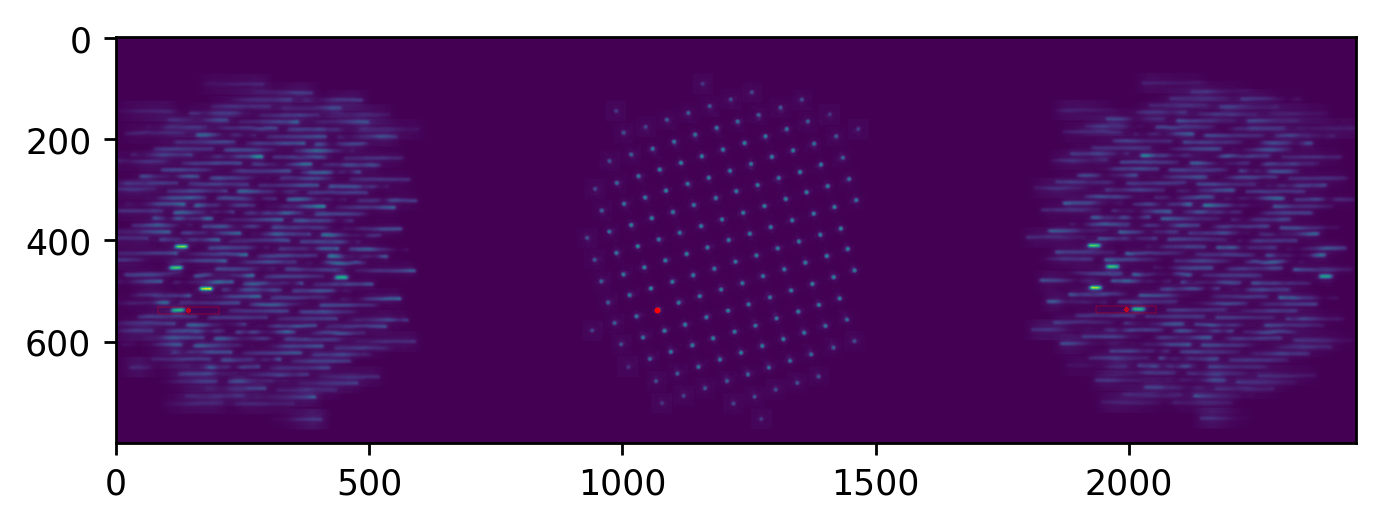

In [38]:
peakno = 3

plt.figure(dpi=250)

plot_measurement = measurement.clone()
plot_measurement[...,800:1700] = plot_measurement[...,800:1700]/10 

plt.imshow(plot_measurement[0].cpu())

plt.scatter(center_wl_peak_positions_m1[peakno,1],center_wl_peak_positions_m1[peakno,0],c='r',s=.1)
plt.scatter(center_wl_peak_positions_f[peakno,1],center_wl_peak_positions_f[peakno,0],c='r',s=.5)
plt.scatter(center_wl_peak_positions_p1[peakno,1],center_wl_peak_positions_p1[peakno,0],c='r',s=.1)

from matplotlib.patches import Rectangle

rect = Rectangle((center_wl_peak_positions_m1[peakno,1]-box_size,center_wl_peak_positions_m1[peakno,0]-border),box_size*2+1,border*2+1,linewidth=.1,edgecolor='r',facecolor='none')
plt.gca().add_patch(rect)
rect2 = Rectangle((center_wl_peak_positions_p1[peakno,1]-box_size,center_wl_peak_positions_p1[peakno,0]-border),box_size*2+1,border*2+1,linewidth=.1,edgecolor='r',facecolor='none')
plt.gca().add_patch(rect2)



In [28]:
import h5py


In [58]:
import h5py
# file.close()
file = h5py.File('/project/agdoepp/Howard/microlens_dataset_2.h5','w')
n_cubes = 500

file.create_dataset('correlation_matrix', data = correlation_matrix.cpu().numpy())

file.create_dataset('m1', shape = (n_cubes * num_peaks,2*border+1,2*box_size+1))
file.create_dataset('f', shape = (n_cubes * num_peaks,2*fborder+1,2*fborder+1))
file.create_dataset('p1', shape = (n_cubes * num_peaks,2*border+1,2*box_size+1))
file.create_dataset('f_peak_locs', shape = (n_cubes * num_peaks,2))
file.create_dataset('intensity', shape = (n_cubes * num_peaks,latentsize))
file.create_dataset('phase_x', shape=(n_cubes * num_peaks,latentsize))
file.create_dataset('phase_y', shape=(n_cubes * num_peaks,latentsize))

calibrated = True

for i in range(n_cubes): # 
    print(i, end='\r')
    new_intensities = torch.stack([create_random_smooth_array(latentsize, positive=True,smoothness=2) for null in range(len(calibration_neighbour_peaks))]).permute(1,0)

    
    new_phase_x = torch.stack([create_random_smooth_array(latentsize, max_val = (torch.rand(1) - .5) * 4 ,smoothness=2) for null in range(len(calibration_neighbour_peaks))]).permute(1,0)
    new_phase_y = torch.stack([create_random_smooth_array(latentsize, max_val = (torch.rand(1) - .5) * 4 ,smoothness=2) for null in range(len(calibration_neighbour_peaks))]).permute(1,0)

    up_new_intensities = correlation_matrix @ new_intensities
    up_new_phase_x = correlation_matrix @ new_phase_x
    up_new_phase_y = correlation_matrix @ new_phase_y


    newcube = simulate_measurement(normalized_just_funda, up_new_intensities, up_new_phase_x, up_new_phase_y, calibration_neighbour_peaks, kernel, grating_modulation_m1, grating_modulation_p1)

    measurement = newcube.sum(1).cpu().numpy()

    if calibrated:
        neighbour_peaks = calibration_neighbour_peaks[:num_peaks] 
    else:
        raise NotImplementedError('Sunny you need to reindex the intensities and phases with the new peak locations.')

        neighbour_peaks = peak_local_max(measurement[0,:,900:1500], min_distance=30, threshold_rel = 0.01) + np.array([0,900])[None,:]

        neighbour_peaks = neighbour_peaks[:num_peaks]




    center_wl_peak_positions_m1_exact = neighbour_peaks + abs_dispersion_minus1[:,mid_wl][None]
    center_wl_peak_positions_m1 = np.round(center_wl_peak_positions_m1_exact).astype(int)
    # m1_rounding_correction = center_wl_peak_positions_m1_exact - center_wl_peak_positions_m1

    center_wl_peak_positions_p1_exact = neighbour_peaks + abs_dispersion_plus1[:,mid_wl][None]
    center_wl_peak_positions_p1 = np.round(center_wl_peak_positions_p1_exact).astype(int)
    # p1_rounding_correction = center_wl_peak_positions_p1_exact - center_wl_peak_positions_p1

    center_wl_peak_positions_f = np.round(neighbour_peaks).astype(int)

    if any(center_wl_peak_positions_m1[:,1] - box_size < 0) or any(center_wl_peak_positions_p1[:,1] + box_size > cube.shape[2]):
        print('crash')
        break


    for j in range(num_peaks):
        file['intensity'][i*num_peaks + j] = new_intensities[:,j].cpu().numpy()
        file['phase_x'][i*num_peaks + j] = new_phase_x[:,j].cpu().numpy()
        file['phase_y'][i*num_peaks + j] = new_phase_y[:,j].cpu().numpy()

        m1 = measurement[0,center_wl_peak_positions_m1[j,0]-border:center_wl_peak_positions_m1[j,0]+border+1,center_wl_peak_positions_m1[j,1]-box_size:center_wl_peak_positions_m1[j,1]+box_size+1]
        p1 = measurement[0,center_wl_peak_positions_p1[j,0]-border:center_wl_peak_positions_p1[j,0]+border+1,center_wl_peak_positions_p1[j,1]-box_size:center_wl_peak_positions_p1[j,1]+box_size+1]
        f = measurement[0,center_wl_peak_positions_f[j,0]-fborder:center_wl_peak_positions_f[j,0]+fborder+1,center_wl_peak_positions_f[j,1]-fborder:center_wl_peak_positions_f[j,1]+fborder+1]


        file['m1'][i*num_peaks + j] = m1 + np.random.randn(*m1.shape) * m1.max() * .01
        file['f'][i*num_peaks + j] = f + np.random.randn(*f.shape) * m1.max() * .01
        file['p1'][i*num_peaks + j] = p1 + np.random.randn(*p1.shape) * m1.max() * .01

        file['f_peak_locs'][i*num_peaks + j] = neighbour_peaks[j]

    



file.close()

[ 431. 1403.]


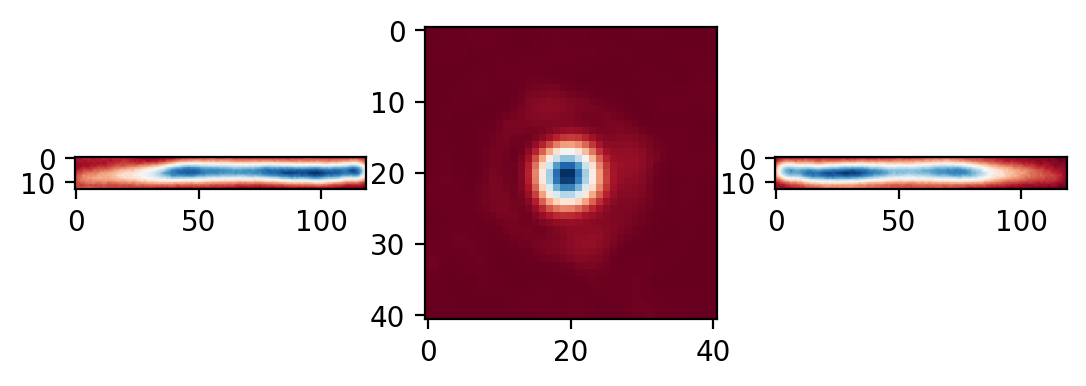

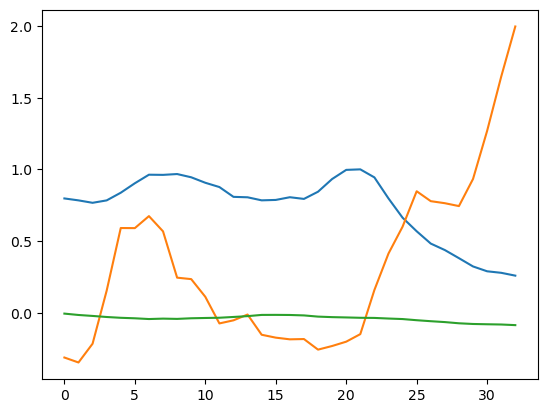

In [29]:
file = h5py.File('/project/agdoepp/Howard/microlens_dataset_2.h5','r')

i = 11 # torch.randint(0,10,(1,)).item()

m1 = file['m1'][i]
f = file['f'][i]
p1 = file['p1'][i]
f_peak_locs = file['f_peak_locs'][i]
intensity = file['intensity'][i]
phase_x = file['phase_x'][i]
phase_y = file['phase_y'][i]

fig,ax = plt.subplots(1,3,dpi=200)
ax[0].imshow(m1,cmap='RdBu')
ax[1].imshow(f,cmap='RdBu')
ax[2].imshow(p1,cmap='RdBu')
fig = plt.figure()
plt.plot(intensity)
plt.plot(phase_x)
plt.plot(phase_y)

print(f_peak_locs)

file.close()

### Prepare the data for the actual measurement

In [40]:
measurement = cube.sum(0).cpu().unsqueeze(0).numpy()

file = h5py.File('/project/agdoepp/Howard/microlens_dataset_2.h5','a')

n_cubes = 1

file.create_dataset('m1_real', shape = (n_cubes * num_peaks,2*border+1,2*box_size+1))
file.create_dataset('f_real', shape = (n_cubes * num_peaks,2*fborder+1,2*fborder+1))
file.create_dataset('p1_real', shape = (n_cubes * num_peaks,2*border+1,2*box_size+1))
file.create_dataset('f_peak_locs_real', shape = (n_cubes * num_peaks,2))
file.create_dataset('intensity_real', shape = (n_cubes * num_peaks,latentsize))
file.create_dataset('phase_x_real', shape=(n_cubes * num_peaks,latentsize))
file.create_dataset('phase_y_real', shape=(n_cubes * num_peaks,latentsize))


correlation_matrix_inv = np.linalg.pinv(correlation_matrix.cpu().numpy())
i = 0
for j in range(num_peaks):

    center_wl_peak_positions_m1_exact = neighbour_peaks + abs_dispersion_minus1[:,mid_wl][None]
    center_wl_peak_positions_m1 = np.round(center_wl_peak_positions_m1_exact).astype(int)
    # m1_rounding_correction = center_wl_peak_positions_m1_exact - center_wl_peak_positions_m1

    center_wl_peak_positions_p1_exact = neighbour_peaks + abs_dispersion_plus1[:,mid_wl][None]
    center_wl_peak_positions_p1 = np.round(center_wl_peak_positions_p1_exact).astype(int)
    # p1_rounding_correction = center_wl_peak_positions_p1_exact - center_wl_peak_positions_p1

    center_wl_peak_positions_f = np.round(neighbour_peaks).astype(int)

    m1 = measurement[0,center_wl_peak_positions_m1[j,0]-border:center_wl_peak_positions_m1[j,0]+border+1,center_wl_peak_positions_m1[j,1]-box_size:center_wl_peak_positions_m1[j,1]+box_size+1]
    p1 = measurement[0,center_wl_peak_positions_p1[j,0]-border:center_wl_peak_positions_p1[j,0]+border+1,center_wl_peak_positions_p1[j,1]-box_size:center_wl_peak_positions_p1[j,1]+box_size+1]
    f = measurement[0,center_wl_peak_positions_f[j,0]-fborder:center_wl_peak_positions_f[j,0]+fborder+1,center_wl_peak_positions_f[j,1]-fborder:center_wl_peak_positions_f[j,1]+fborder+1]

    norm = f.sum()

    m1 = m1 / norm
    p1 = p1 / norm
    f = f / norm

    true_spectra = cube[:,center_wl_peak_positions_f[j,0]-fborder:center_wl_peak_positions_f[j,0]+fborder+1,center_wl_peak_positions_f[j,1]-fborder:center_wl_peak_positions_f[j,1]+fborder+1].sum((1,2)).cpu().numpy() 
    true_spectra = correlation_matrix_inv @ true_spectra
    true_spectra = true_spectra / true_spectra.max()

    file['intensity_real'][i*num_peaks + j] = true_spectra  
    file['phase_x_real'][i*num_peaks + j] = np.zeros_like(true_spectra)
    file['phase_y_real'][i*num_peaks + j] = np.zeros_like(true_spectra)

    file['m1_real'][i*num_peaks + j] = m1
    file['f_real'][i*num_peaks + j] = f
    file['p1_real'][i*num_peaks + j] = p1
    file['f_peak_locs_real'][i*num_peaks + j] = neighbour_peaks[j]
    




    

In [41]:
file.close()

### Zernike Stuff

In [66]:
import LightPipes as lp
from skimage.restoration import unwrap_phase
#import subpixel shift
from scipy.ndimage import shift


def make_zernike_profile(zernikes):
    n_zernike = len(zernikes)
    size = 200*lp.um

    F=lp.Begin(size=size,labda=800*lp.nm,N=100) # initiate
        

    for Noll in range(1, n_zernike+1):
            (nz, mz) = lp.noll_to_zern(Noll) #converting between int and zernike coeffs
            e_m = 2 if mz == 0 else 1
            A = 1
            F = lp.Zernike(F, nz, mz, size, zernikes[Noll-1] * A, units='lam')
    return unwrap_phase(lp.Phase(F))


def get_zernike_shifts(zernike_coefficients, normalized_relative_peak_locations):
    zernike_profile = make_zernike_profile(zernike_coefficients)
    shift_x, shift_y = np.gradient(zernike_profile)

    x_shifts = nn.functional.grid_sample(torch.tensor(shift_x)[None,None], normalized_relative_peak_locations[None,None])[0,0,0]
    y_shifts = nn.functional.grid_sample(torch.tensor(shift_y)[None,None], normalized_relative_peak_locations[None,None])[0,0,0]

    return x_shifts, y_shifts


def shift_peaks(slice, shifts, relative_peaks, funda_main_peak, minus1_main_peak, plus1_main_peak, border = 20):
    '''
    shift peaks for a single wl slice.
    '''

    warped_slice = slice.clone()

    funda_peaks = (funda_main_peak[None,:] + relative_peaks).astype(int)
    minus1_peaks = (minus1_main_peak[None,:] + relative_peaks).astype(int)
    plus1_peaks = (plus1_main_peak[None,:] + relative_peaks).astype(int)

    for i in range(len(relative_peaks)):
        warped_slice[funda_peaks[i,0]-border:funda_peaks[i,0]+border,funda_peaks[i,1]-border:funda_peaks[i,1]+border] = torch.tensor(shift(slice[funda_peaks[i,0]-border:funda_peaks[i,0]+border,funda_peaks[i,1]-border:funda_peaks[i,1]+border] , shift = (shifts[i,0],shifts[i,1]), order = 1))
        warped_slice[minus1_peaks[i,0]-border:minus1_peaks[i,0]+border,minus1_peaks[i,1]-border:minus1_peaks[i,1]+border] = torch.tensor(shift(slice[minus1_peaks[i,0]-border:minus1_peaks[i,0]+border,minus1_peaks[i,1]-border:minus1_peaks[i,1]+border] , shift = (shifts[i,0],shifts[i,1]), order = 1))
        warped_slice[plus1_peaks[i,0]-border:plus1_peaks[i,0]+border,plus1_peaks[i,1]-border:plus1_peaks[i,1]+border] = torch.tensor(shift(slice[plus1_peaks[i,0]-border:plus1_peaks[i,0]+border,plus1_peaks[i,1]-border:plus1_peaks[i,1]+border] , shift = (shifts[i,0],shifts[i,1]), order = 1))
    
    return warped_slice
        


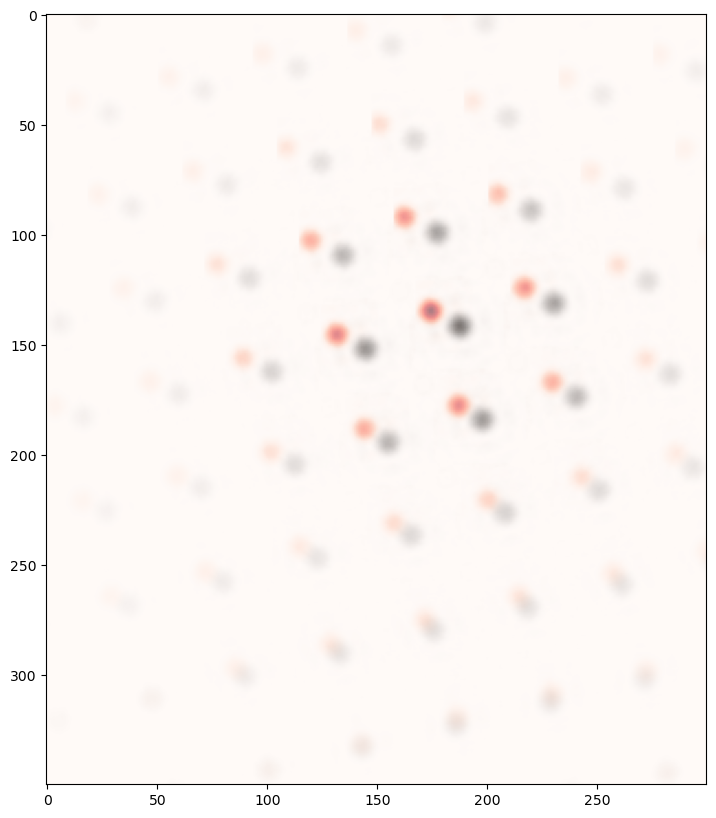

In [248]:
n_zernikes = 10
zernikes = np.zeros((n_zernikes))
zernikes[2] = 1
zernikes = np.random.rand((n_zernikes))

normalized_relative_peaks = torch.tensor((relative_peaks - relative_peaks.min()) / (relative_peaks.max() - relative_peaks.min()))

f = 5.6*lp.mm


shift_x, shift_y = get_zernike_shifts(zernikes,normalized_relative_peaks)
shifts = torch.stack([shift_x,shift_y],dim=1) * 50


shifted = shift_peaks(cube[wl],shifts,relative_peaks,peak_loc_funda,peak_loc_minus1[:,wl],peak_loc_plus1[:,wl])
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(cube[wl,250:600,1000:1300],cmap='gray_r')
ax.imshow(shifted[250:600,1000:1300],alpha=0.5,cmap='Reds')